In [152]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from tqdm import tqdm
import pandas as pd
import string
from typing import Optional

In [2]:
from navec import Navec
path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

In [54]:
data = pd.read_csv('keyPhrases.csv', header=None)

In [55]:
data

,0
0,интеллектуальный капитал
1,оценка уровня интеллектуального капитала вуза
2,интеграционные объединения
3,гармонизация отношений
4,единое информационное пространство
...,...
1325,регионы
1326,стоимость предприятия
1327,проекты развития
1328,инновации


In [56]:
class PhraseEmbeddings:
    def __init__(self, phrase, embbedings):
        self.phrase: string = phrase
        self.embbedings: [float] = embbedings

def calculateEmbeddingsForSplittedPhrase(phrase: [string]) -> Optional[PhraseEmbeddings]:
    embeddings: [[]] = []
        
    for word in phrase:
        tempEmbedding = navec.get(word)

        if tempEmbedding is not None:
            embeddings.append(tempEmbedding)

    if len(embeddings) != 0:
        return PhraseEmbeddings(' '.join(phrase), np.mean(embeddings, axis=0))
    else:
        # return None -> if navec could not determine the embeddings of all words of the phrase.
        return None

In [103]:
emb = []
phrases = []
i = 0
for row in data[0]:
    if len(row.split()) == 1:
        res = navec.get(row)
        if res is not None:
            emb.append(res)
            phrases.append(row)
    else:
        res = calculateEmbeddingsForSplittedPhrase(np.array(row.split()))
        if res is not None:
            emb.append(res.embbedings)
            phrases.append(row)

In [105]:
Z = np.array(phrases)

In [108]:
Z.shape

(1281,)

In [76]:
X = np.array(emb)

In [77]:
X.shape

(1281, 300)

In [44]:
np.random.seed(48)

In [85]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))


class KMean:
    def __init__(self, K=5, max_iters=100, plot_steps=False):
        self.K = K
        self.max_iters = max_iters
        self.plot_steps = plot_steps

        # list of samples indices for each cluster
        self.clusters = [[] for _ in range(self.K)]
        # mean feature vector for each cluster
        self.centroinds = []

    def predict(self, X):
        self.X = X
        self.n_samples, self.n_feature = X.shape

        # initialize centroids
        random_sample_idxs = np.random.choice(self.n_samples, self.K, replace=False)
        self.centroinds = [self.X[idx] for idx in random_sample_idxs]
        # optimization
        for _ in range(self.max_iters):
            # update clusters
            self.clusters = self._create_clusters(self.centroinds)
            if self.plot_steps:
                self.plot()
            # update centroids
            centroids_old = self.centroinds
            self.centroinds = self._get_centroids(self.clusters)
            #if plot_steps: self.plot()
            # check if converged
            if self._is_converged(centroids_old, self.centroinds):
                break
        # return cluster labels
        return self._get_cluster_labels(self.clusters)
#        return self.clusters

    def _get_cluster_labels(self, clusters):
        labels = np.zeros(self.n_samples, dtype='int16')
        for cluster_idx, cluster in enumerate(clusters):
            for sample_idx in cluster:
                labels[sample_idx] = cluster_idx
        return labels

    def _create_clusters(self, centroids):
        clusters = [[] for _ in range(self.K)]
        for idx, sample in enumerate(self.X):
            centroid_idx = self._closest_centroid(sample, centroids)
            clusters[centroid_idx].append(idx)
        return clusters

    def _closest_centroid(self, samples, centroids):
        distances = [euclidean_distance(samples, point) for point in centroids]
        closest_idx = np.argmin(distances)
        return closest_idx

    def _get_centroids(self, clusters):
        centroids = np.zeros((self.K, self.n_feature))
        for cluster_idx, cluster in enumerate(clusters):
            cluster_mean = np.mean(self.X[cluster], axis=0)
            centroids[cluster_idx] = cluster_mean
        return centroids

    def _is_converged(self, centroids_old, centroids):
        distances = [euclidean_distance(centroids_old[i], centroids[i]) for i in range(self.K)]
        return sum(distances) == 0

    def plot(self):
        fig, ax = plt.subplots(figsize=(12, 8))

        for i, index in enumerate(self.clusters):
            point = self.X[index].T
            ax.scatter(*point)

        for point in self.centroinds:
            ax.scatter(*point, marker="x", color="black", linewidths=2)

        plt.show()

In [77]:
# n_samples = 1330, n_features = 300 

#X, y = make_blobs(centers=3, n_samples=500, n_features=2, shuffle=True, random_state=48)
#print(X.shape)

(500, 2)


In [7]:
#clusters = len(np.unique(y))
#print(clusters)

3


In [92]:
s = []
k_max = 10

for k in tqdm(range(2,k_max+1)):
    y_pred = KMean(k).predict(X)
    s1 = silhouette_score(X, y_pred)
    s.append(s1)
    
print(s)

100%|██████████| 9/9 [00:42<00:00,  4.69s/it]

[0.042182427, 0.06277062, 0.05752994, 0.050447207, 0.062023655, 0.053930223, 0.08093779, 0.081212096, 0.07802115]


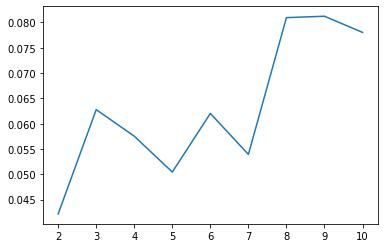

In [93]:
plt.plot(range(2,k_max+1), s)

In [145]:
y_pred = KMean(K=8).predict(X)

In [153]:
kmm = KMeans(n_clusters=8)
kmm.fit(X)

KMeans()

(array([ 76., 217., 291.,  50., 163., 184., 249.,  51.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <BarContainer object of 8 artists>)

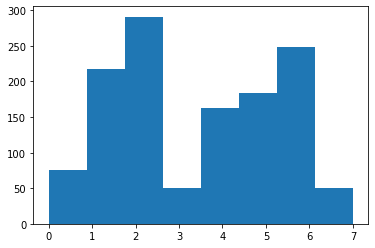

In [156]:
y_pred = kmm.labels_
plt.hist(y_pred, bins=8)

In [167]:
clusters = kmm.cluster_centers_
clusters.shape
pd.DataFrame(clusters).to_csv('clusters_1.csv', header=False)

In [138]:
len(y_pred)

1281

(array([156.,  65.,  56., 199., 258.,   3., 393., 151.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <BarContainer object of 8 artists>)

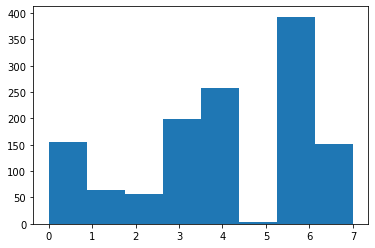

In [139]:
plt.hist(y_pred, bins=8)

In [159]:
topics = []
for i in range(8):
    topics.append(list())
    
for i, y in enumerate(y_pred):
    #topics[y].append((i,Z[i]))
    topics[y].append(Z[i])

In [168]:
topics[0]

['конкурентоспособность промышленных предприятий',
 'стоимость',
 'конкурентоспособность',
 'качество',
 'повышение конкурентоспособности',
 'эффективность',
 'оценка рисков',
 'концентрация рынка банкострахования',
 'региональная эффективность',
 'конкурентоспособность',
 'цена',
 'заработная плата',
 'эффективность',
 'экономическая эффективность',
 'экономическая эффективность',
 'оценка инвестиций',
 'стоимость',
 'оценка сost',
 'производительность труда',
 'устойчивость',
 'конкурентоспособность',
 'эффективность деятельности',
 'эффективность',
 'индикативный показатель',
 'конкуренция и конкурентоспособность',
 'эффективность деятельности',
 'экономическая эффективность',
 'снижение затрат',
 'ликвидность',
 'платежеспособность',
 'эффективность процессов',
 'конкурентоспособность',
 'оценка стоимости',
 'надежность изделий',
 'цена',
 'ключевые показатели эффективности',
 'показатели',
 'ликвидность',
 'платежеспособность',
 'показатели эффективности планирования',
 'абсолютны